# **Tool Preparation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import time
%matplotlib inline

# **Data Extraction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!tar --gunzip --extract --verbose --file=/content/drive/MyDrive/cifar-10-python.tar.gz

Mounted at /content/drive
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


# **Data Preprocessing**

### **Create Change Data Type**

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### **Create Plot Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### **Read Data from Path**

In [ ]:
def load_data(path):
    filename = path + 'data_batch_'
    data = [i for i in range(7)]

    for i in range(len(data)):
        if i != 0 and i != 6:
            data[i] = unpickle(filename + str(i))
    
    data[0] = unpickle(path + 'batches.meta')
    data[6] = unpickle(path + 'test_batch')
    # Load all batches(train & test) to a list and return it
    
    return data

# where data stored
data_dir = '/content/cifar-10-batches-py/'
# data_dir = 'cifar10/'

all_data = load_data(data_dir)

In [ ]:
batches = all_data[0]     # label names
label_name = batches[b'label_names']
print(label_name)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# **Split Data and Normalize Data**

In [ ]:
def train_test_normal(data):
    
    '''--------------------------------------- split data ----------------------------------------'''
    # attach all data from list to a numpy array X_train, Y_train
    for i in range(1, 6):
        x_data = all_data[i][b'data']
        y_data = np.array(all_data[i][b"labels"])
        if i == 1:
            X_train = x_data
            Y_train = y_data
        else:
            X_train = np.concatenate((X_train, x_data), axis = 0)
            Y_train = np.concatenate((Y_train, y_data), axis = 0)

    # stored test data in X_test, Y_tests
    X_test = all_data[6][b'data']
    Y_test = np.array(all_data[6][b"labels"])
    
    '''------------------------------------ Normalize data ----------------------------------------'''
    # change data shape 3072---> 3, 32, 32 ---> transpose 32, 32, 3
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint8')

    # Normalize Data
    X_train = X_train / 255.
    X_test = X_test / 255.
    # X = (X - X.min()) / (X.max() - X.min())  ---> X /= 255.0
    # X.min() = 0
    # X.max() = 255
    
    # Print shape of Data to better Understanding
    print(X_train.shape)
    print(Y_train.shape)
    print("-------")
    print(X_test.shape)
    print(Y_test.shape)
    # return train, test Data
    return X_train, Y_train, X_test, Y_test

# **Visualize Data**

In [ ]:
X_train, Y_train, X_test, Y_test = train_test_normal(all_data)

(50000, 32, 32, 3)
(50000,)
-------
(10000, 32, 32, 3)
(10000,)


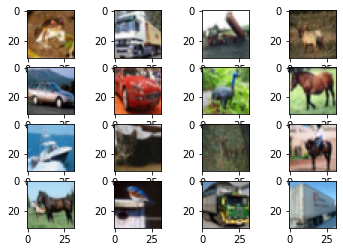

In [ ]:
row, column = 4, 4
for i in range(row * column):
    plt.subplot(row, column, i + 1)
    plt.imshow(X_train[i])
plt.show()

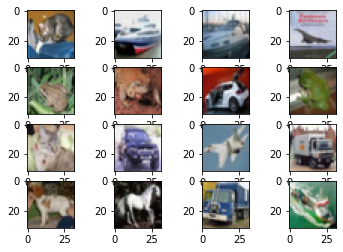

In [ ]:
row, column = 4, 4
for i in range(row * column):
    plt.subplot(row, column, i + 1)
    plt.imshow(X_test[i])
plt.show()

# **Clusification Model With Artificial Neural Network**

## **Model Creation**

### **Creat ANN Model**

In [ ]:
def model_creation(layers, neurons, activation_func):
    model = Sequential(Flatten(input_shape=(32, 32, 3)))
    try:
        if layers > 0:
            for i in range(layers):
                model.add(Dense(neurons[i], activation=activation_func))
                # Hidden Layer Addition
        # output Layer
        model.add(Dense(10, activation='softmax'))
        
        print(model.summary())
        
    except TypeError:
        print('neurons type is list!')
    
    return model

### **Creat Accuracy dan Loss Plot**

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    # Plot both Loss & Accuracy in Subplot
  # creat accuracy plot
    axs[0].plot(history.history['acc'], label='train accuracy')
    axs[0].plot(history.history['val_acc'], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy eval')

  # creat loss plot
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='test loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Loss eval')

    plt.show()


def compile_fit_plot(model, learning_Rate, train_data, valid_data, batch_Size, Epochs):
    # Compile model with user learning rate, data, batch_size and epochs
    try:
        model.compile(optimizer=Adam(learning_rate=learning_Rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
        # Visualize model performance in tensorboard
        name = 'cifar 10 model{}'.format(time.ctime())
        tensorCall = TensorBoard(log_dir='logs/{}'.format(name))
        # train model
        history = model.fit(train_data[0], train_data[1], batch_size=batch_Size, 
                             epochs=Epochs, validation_data=valid_data, callbacks=[tensorCall])
    
        # plt.plot(history.history['loss'], 'b-')
        # plt.plot(history.history['val_loss'], 'r-')
        # plt.ylabel('loss')
        
        # plot model Loss and Accuracy in 1 line
        plot_history(history)
        
    except ValueError:
        print('\nvalid_data type is tuple')

### **Create Predict Test Data and Confusion Matrix**

In [ ]:
def prediction_test(model, test_data):
    # model performance on test Data
    y_predict = model.predict(test_data[0])
    Y_predict = np.argmax(y_predict, axis=1)
    # Plot Confusion Matrix
    confiusionM = confusion_matrix(test_data[1], Y_predict)
    
    plot_confusion_matrix(cm=confiusionM, title='Confiusion', target_names=label_name, normalize=False)

## **Running ANN : One Layer**

In [ ]:
model_1 = model_creation(1, [300], 'relu')
# one layer with best score on test 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/80
782/782 [==============================] - 5s 3ms/step - loss: 1.8735 - acc: 0.3355 - val_loss: 1.8063 - val_acc: 0.3430
Epoch 2/80
782/782 [==============================] - 2s 3ms/step - loss: 1.7144 - acc: 0.3996 - val_loss: 1.6503 - val_acc: 0.4186
Epoch 3/80
782/782 [==============================] - 2s 3ms/step - loss: 1.6417 - acc: 0.4237 - val_loss: 1.6090 - val_acc: 0.4402
Epoch 4/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5959 - acc: 0.4409 - val_loss: 1.5851 - val_acc: 0.4444
Epoch 5/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5541 - acc: 0.4578 - val_loss: 1.5492 - val_acc: 0.4639
Epoch 6/80
782/782 [==============================] - 2s 3ms/step - loss: 1.5203 - acc: 0.4691 - val_loss: 1.5440 - val_acc: 0.4605
Epoch 7/80
782/782 [==============================] - 2s 3ms/step - loss: 1.4919 - acc: 0.4802 - val_loss: 1.5085 - val_acc: 0.4733
Epoch 8/80
782/782 [==============================] - 2s 3ms/step - loss: 1.

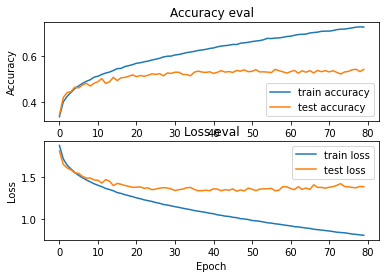

In [ ]:
compile_fit_plot(model_1, 0.0001, [X_train, Y_train], (X_test, Y_test), 64, 80)

# **Model Result and Validation**

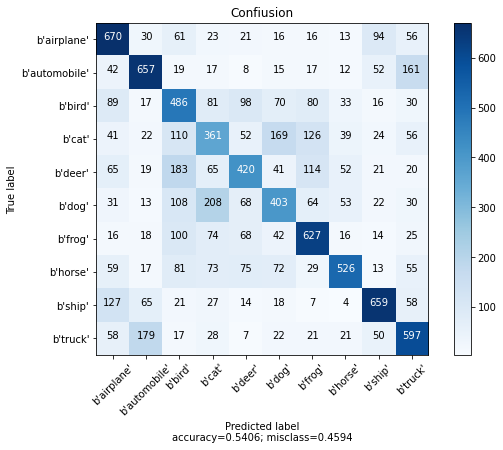

In [ ]:
prediction_test(model_1, [X_test, Y_test])

In [ ]:
y_predict1 = model_1.predict(X_test)
Y_predict1 = np.argmax(y_predict1, axis=1)
# model_"i" score ---> Y_predict"i" 
# for Precision, recall, F1 score

In [ ]:
for i in range(10):
    true_positive = np.sum((Y_predict1 == i) * (Y_test == i))
    true_negative = np.sum((Y_predict1 != i) * (Y_test != i))
    false_positive = np.sum((Y_predict1 == i) * (Y_test != i))
    false_negative = np.sum((Y_predict1 != i) * (Y_test == i))

    acc = (true_positive + true_negative) / (X_test.shape[0]) * 100
    precision = true_positive / (true_positive + false_positive) * 100
    recall = true_positive / (true_positive + false_negative) * 100
    F1 = 2 * ((precision * recall) / (precision + recall))
    
    print('on label {}, acc={:0.2f}, precision={:0.2f}, recall={:0.2f}, F1 Score={:0.2f}'.format(label_name[i], acc, precision, recall, F1))

on label b'airplane', acc=91.42, precision=55.93, recall=67.00, F1 Score=60.96
on label b'automobile', acc=92.77, precision=63.36, recall=65.70, F1 Score=64.51
on label b'bird', acc=87.86, precision=40.98, recall=48.60, F1 Score=44.46
on label b'cat', acc=87.65, precision=37.72, recall=36.10, F1 Score=36.89
on label b'deer', acc=90.09, precision=50.54, recall=42.00, F1 Score=45.88
on label b'dog', acc=89.38, precision=46.43, recall=40.30, F1 Score=43.15
on label b'frog', acc=91.53, precision=56.95, recall=62.70, F1 Score=59.69
on label b'horse', acc=92.83, precision=68.40, recall=52.60, F1 Score=59.47
on label b'ship', acc=93.53, precision=68.29, recall=65.90, F1 Score=67.07
on label b'truck', acc=91.06, precision=54.87, recall=59.70, F1 Score=57.18


In [ ]:
print(classification_report(Y_test, Y_predict1))
# Another way to Precision, recall, F1 score

              precision    recall  f1-score   support

           0       0.56      0.67      0.61      1000
           1       0.63      0.66      0.65      1000
           2       0.41      0.49      0.44      1000
           3       0.38      0.36      0.37      1000
           4       0.51      0.42      0.46      1000
           5       0.46      0.40      0.43      1000
           6       0.57      0.63      0.60      1000
           7       0.68      0.53      0.59      1000
           8       0.68      0.66      0.67      1000
           9       0.55      0.60      0.57      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000

